# Imports

In [2]:
import os
import numpy as np
import pandas as pd
from unidecode import unidecode
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import seaborn as sns
from google.cloud import storage
from ydata_profiling import ProfileReport
import math
import requests
import bs4
import re

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funções Auxiliares

In [3]:
def get_data(bucket_name:str, imobiliarias:str = ['apolar', 'cilar'],by:str = ['date','date_diff'], dates:list = [], date_diff:int = 2):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    files_on_bucket = [i.name for i in bucket.list_blobs()]
    files = pd.DataFrame(files_on_bucket, columns=['name'])
    files['date'] = pd.to_datetime(files['name'].apply(lambda f: f.split(' - ')[0]))
    files['imobiliaria'] = files['name'].apply(lambda f: f.split(' - ')[-1].replace('.csv',''))

    match by:
        case 'date':
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
        case 'date_diff':
            dates = files['date'].sort_values(ascending=False).drop_duplicates().reset_index(drop=True)[:date_diff].tolist()
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
    
    df_full = pd.DataFrame()

    for file_name in files['name'].tolist():
        try:
            df_aux = pd.read_csv(f'gs://{bucket_name}/{file_name}')
            df_full = pd.concat([df_full, df_aux], axis = 0)
        except:
            pass

    df_full = df_full.reset_index(drop=True)

    return df_full

def barplot(title:str, 
            group:str, 
            agg:str, 
            agg_name:str, 
            data:pd.DataFrame, 
            agg_func:str, 
            figure= plt.figure, 
            title_font_size:int =10, 
            figsize=(10,5),
            subplot:plt.subplot = None, 
            grid:list = None, 
            orient:str='h',
            label=True,
            rotation_label:int = 45,
            position_label:str = 'center',
            color_label:str = 'white',
            size_label:str = 'small',
            fmt:str = '%.0f',
            sort: bool = True, 
            hue:str = None,
            stacked:bool = False):
    
    group_list = [group]
    if hue:
        group_list.append(hue)

    # group data
    aux = data[group_list + [agg]].groupby(group_list).agg(agg_func).reset_index().rename(columns={agg:agg_name})

    if sort:
        aux = aux.sort_values(agg_name, ascending=False)
        
    # plot
    if subplot:
        subplot(grid)
    else:
        figure(figsize=figsize)

    # plot configs
    plt.title(title, fontsize=title_font_size)
    plt.xticks(rotation = rotation_label)

    # figure
    if orient == 'h':
        g = sns.barplot(x = group, y = agg_name, hue = hue, dodge = not stacked, data = aux)
    elif orient == 'v':
        g = sns.barplot(y = group, x = agg_name, hue = hue, dodge = not stacked, data = aux)
    else:
        raise("Variável 'orient' informada não é válida")

    if label:
        for i in g.containers:
            g.bar_label(i, color = color_label, label_type=position_label, fontsize = size_label, fmt = fmt)
    else:
        pass

def histplot(title:str, col:str, data:pd.DataFrame, figsize=(10,5), label=True):

    plt.figure(figsize=figsize)
    plt.title(title)
    g = sns.histplot(x = col,  data = data)
    plt.xticks(rotation = 45)
    if label:
        for i in g.containers:
            g.bar_label(i, color = 'white',label_type='center')
    else:
        pass

def get_infos_curitiba():

    ## Request site
    response = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba')

    ## beautiful soup object
    soup = bs4.BeautifulSoup(response.content, 'html.parser')

    # tabelas da wikipedia
    infos_tabela = soup.findAll('table', {'class','wikitable'})

    bairros_info_list = []

    ## para cada tabela
    for tabela in infos_tabela:

        # colunas
        columns = [i.text.replace('\n','') for i in tabela.findAll('th')]

        # valores da tabela
        regiao = ' '.join([i.text.replace('\xa0','').replace('\n','') for i in tabela.findAll('td')][0].replace('Bairros oficiais de Curitiba - Regional ','').split(' ')[:-1])
        table_values = [i.text.replace('\xa0','').replace('\n','') for i in tabela.findAll('td')][1::]
        table_values_list = [] 
        for i in range(0,len(table_values),7): 
            table_values_list.append(table_values[i:i+7])

        # preenchenco dicionário
        for b in table_values_list:

            bairros_info_dict = {}
            bairros_info_dict['Região'] = regiao
            bairros_info_dict['Bairro'] = b[0]
            bairros_info_dict['Área (km²)'] = b[1].replace(',','.')
            bairros_info_dict['Homens'] = b[2].replace(',','.')
            bairros_info_dict['Mulheres'] = b[3].replace(',','.')
            bairros_info_dict['Total'] = b[4].replace(',','.')
            bairros_info_dict['Domicilios particulares'] = b[5].replace(',','.')
            bairros_info_dict['Rendimento mensal médio porresponsáveis dos domicílios (R$)'] = b[6].replace(',','.')

            bairros_info_list.append(bairros_info_dict)
    
    return pd.DataFrame(bairros_info_list)

def busca_e_preenche_nulos(data, column, string_search):

    if isinstance(string_search, list):
        for s in string_search:
            data.loc[data[column] == 0, column] = np.nan
            data.loc[data[column].isna(), column] = data.loc[data[column].isna(), 'descricao'].apply(lambda x: 0 if isinstance(x,float) else 
                                                                                                            1 if s in unidecode(x.lower()) else 0)
    elif isinstance(string_search,str):
        data.loc[data[column] == 0, column] = np.nan
        data.loc[data[column].isna(), column] = data.loc[data[column].isna(), 'descricao'].apply(lambda x: 0 if isinstance(x,float) else 
                                                                                                            1 if string_search in unidecode(x.lower()) else 0)
    else:
        raise("Atributo 'string_search' deve ser uma lista ou uma string" )
    
    return data

def extrai_valores_string(string,substring):

    # Padronizar a expressão regular para encontrar a área total
    padrao = f'{substring} (\d+)'

    # Encontrar a área total usando regex
    area_total = re.search(padrao, string)

    if area_total:
        # Extrair o valor numérico da área total
        valor_area = area_total.group(1)
        
        # Remover vírgulas e converter para float
        valor_area = int(valor_area.replace(',', '.'))
        
    else:
        valor_area = 0
    
    return valor_area

def vagas_garagem(descricao):
    # Procura por padrões do tipo 'Garagem: [quantidade]' na descrição
    padrao = r'Garagem: (\d+)'
    resultado = re.search(padrao, descricao)

    if resultado:
        # Se encontrou, retorna a quantidade de vagas
        return int(resultado.group(1))
    else:
        # Se não encontrou ou não há informação sobre vagas, retorna 0
        return 0

def histplot_matrix(data, figsize:tuple = (10,5)):
    n_features = data.shape[1]

    rows = int(np.floor(np.sqrt(n_features)))
    cols = int(np.ceil(n_features/rows))

    grid = gridspec.GridSpec(rows,cols)

    for row in range(rows):
        for col in range(cols):
            n = (row*cols) + col
            if n >= n_features:
                break
            plt.subplot(grid[row,col])
            column_name = data.columns.tolist()[n]
            plt.title(column_name)
            data[column_name].hist(figsize=figsize)


    plt.tight_layout()

# Carregar Dados

In [4]:
df_full = pd.read_csv('anuncios_imoveis_curitiba.csv')

# Análise Descritiva dos Dados

- Quantidade de Dados
- Quantidade de Dados Faltantes
- Tipo de Variáveis
- Estatística Descritiva

In [5]:
df = df_full.copy()

## Dimensão dos Dados

In [6]:
print(f'Total de Linhas {df.shape[0]}')
print(f'Total de Colunas {df.shape[1]}')

Total de Linhas 878
Total de Colunas 22


## Tratando NAs

In [7]:
df.isna().sum()

site               0
titulo             0
link               0
data_coleta        0
endereco           0
bairro             1
cidade             0
aluguel            0
condominio         0
seguro_incendio    0
iptu               0
area               0
quartos            0
suites             0
banheiros          0
vagas_garagem      0
mobiliado          0
piscina            0
academia           0
sacada             0
churrasqueira      0
salao_de_festas    0
dtype: int64

### Removendo NAs

In [8]:
df = df.dropna()

In [9]:
df.isna().sum()

site               0
titulo             0
link               0
data_coleta        0
endereco           0
bairro             0
cidade             0
aluguel            0
condominio         0
seguro_incendio    0
iptu               0
area               0
quartos            0
suites             0
banheiros          0
vagas_garagem      0
mobiliado          0
piscina            0
academia           0
sacada             0
churrasqueira      0
salao_de_festas    0
dtype: int64

## Tipos de Variáveis

In [10]:
df.dtypes

site                object
titulo              object
link                object
data_coleta         object
endereco            object
bairro              object
cidade              object
aluguel            float64
condominio         float64
seguro_incendio    float64
iptu               float64
area               float64
quartos              int64
suites               int64
banheiros            int64
vagas_garagem        int64
mobiliado           object
piscina             object
academia            object
sacada              object
churrasqueira       object
salao_de_festas     object
dtype: object

In [11]:
df['data_coleta']   = pd.to_datetime(df['data_coleta'])
df['quartos']       = df['quartos'].astype('int64')
df['suites']        = df['suites'].astype('int64')
df['banheiros']     = df['banheiros'].astype('int64')
df['vagas_garagem'] = df['vagas_garagem'].astype('int64')

In [12]:
df.dtypes

site                       object
titulo                     object
link                       object
data_coleta        datetime64[ns]
endereco                   object
bairro                     object
cidade                     object
aluguel                   float64
condominio                float64
seguro_incendio           float64
iptu                      float64
area                      float64
quartos                     int64
suites                      int64
banheiros                   int64
vagas_garagem               int64
mobiliado                  object
piscina                    object
academia                   object
sacada                     object
churrasqueira              object
salao_de_festas            object
dtype: object

## Distribuição dos Dados

In [13]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
cat_attributes = cat_attributes.drop(columns=['titulo','link','endereco'])

In [14]:
num_attributes

,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem
0,20000.0,0.00,62.56,0.00,203.0,0,0,0,0
1,12000.0,840.00,71.93,0.00,250.0,3,1,1,3
2,10500.0,1549.67,87.58,21.37,330.0,4,1,1,2
3,7000.0,1690.58,53.19,341.74,163.0,2,1,2,2
4,5000.0,635.61,39.14,230.98,107.0,2,1,4,2
...,...,...,...,...,...,...,...,...,...
873,850.0,320.00,0.00,42.25,52.0,2,0,1,1
874,850.0,465.00,0.00,52.99,52.0,2,0,1,0
875,800.0,382.00,0.00,51.19,48.0,1,0,1,0
876,750.0,526.74,0.00,20.62,29.0,1,0,1,0


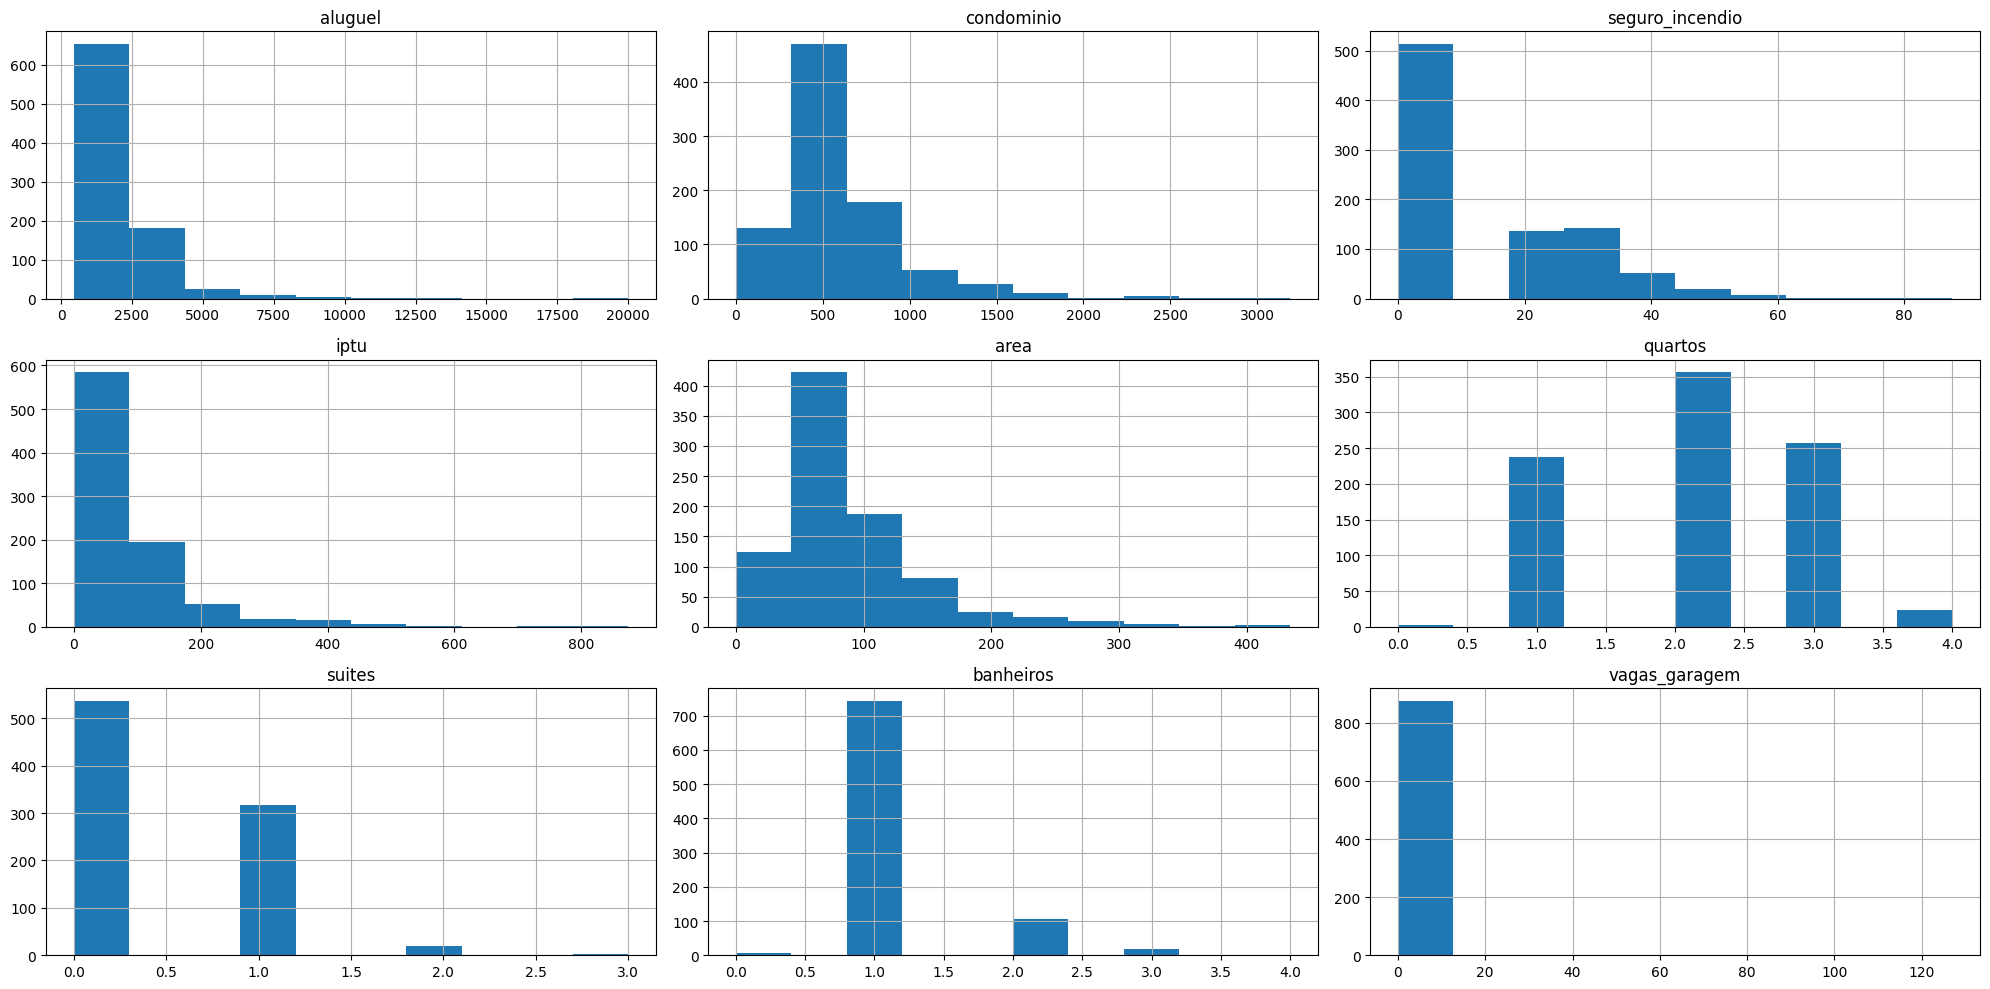

In [15]:
histplot_matrix(num_attributes, figsize=(20,10))

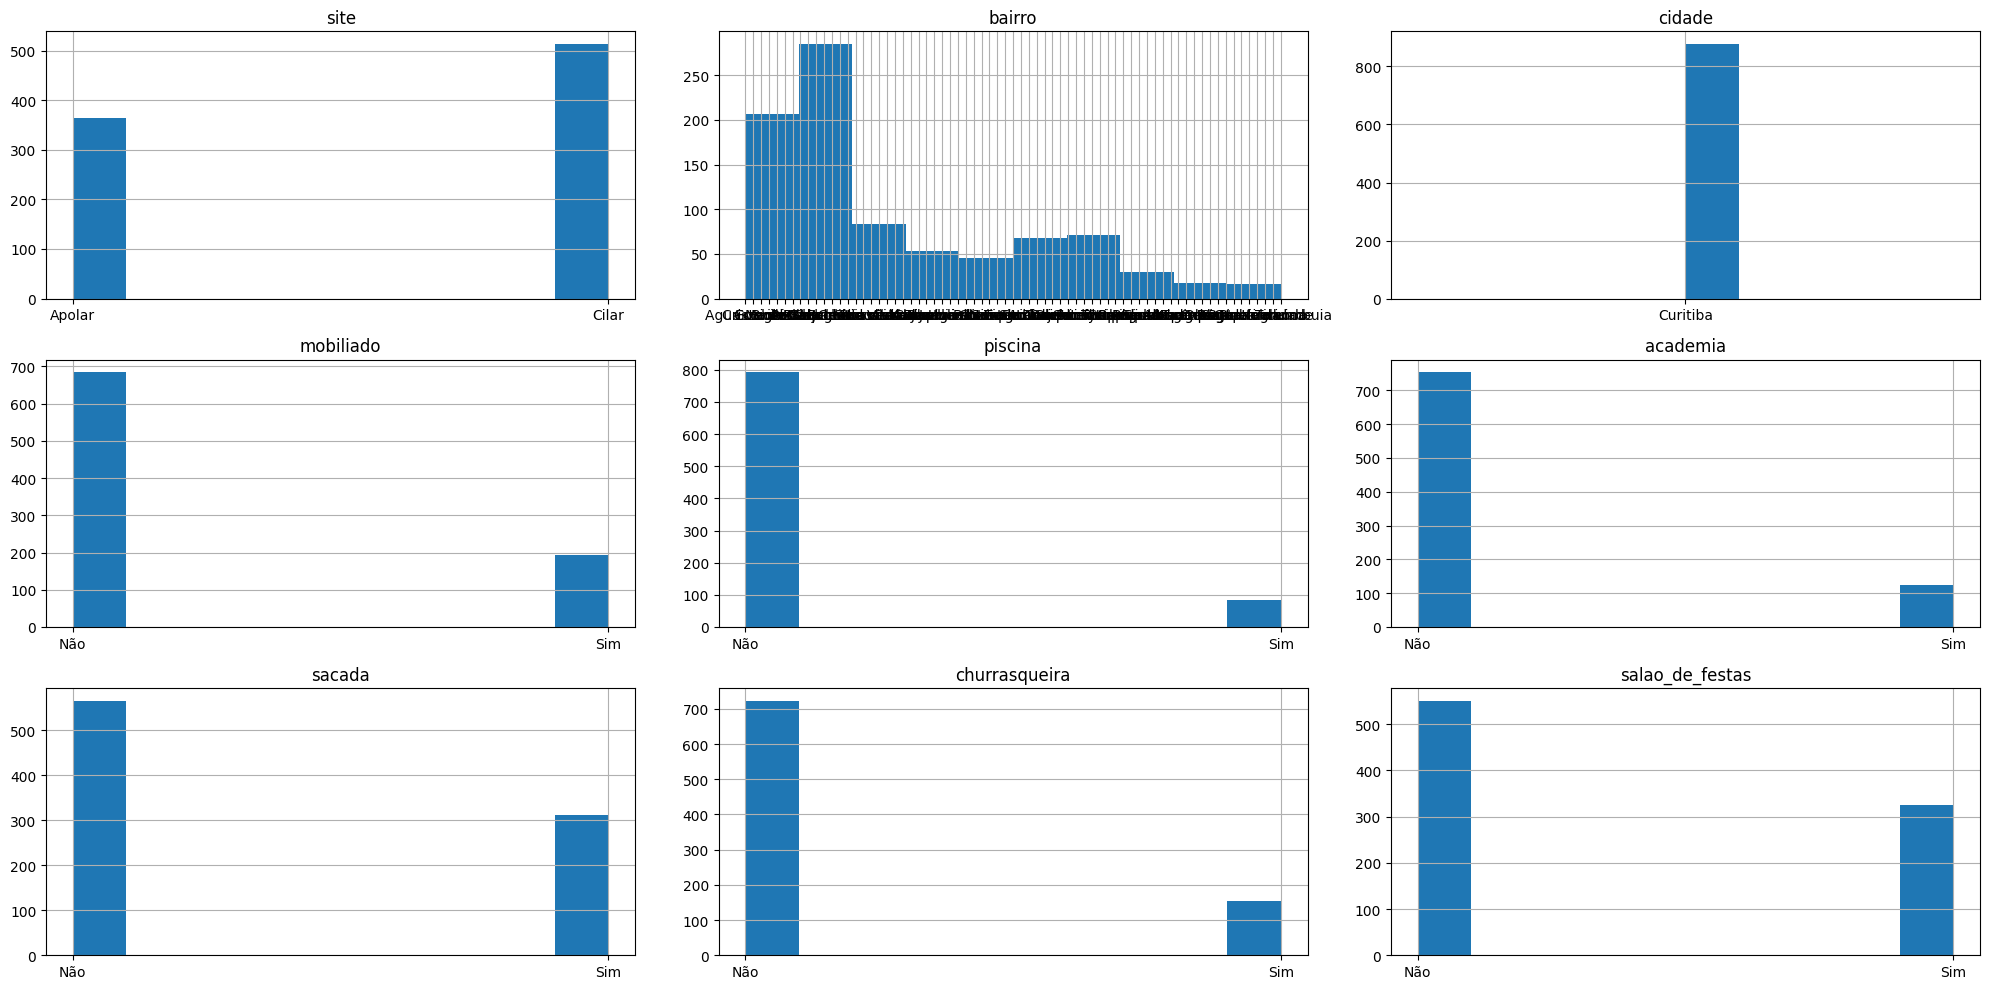

In [16]:
histplot_matrix(cat_attributes, figsize = (20,10))

Notamos aqui que possuimos valores extremos de 'aluguel' e 'vagas_garagem'que indicam a presença de outliers

Vamos investigar esses valores:

## Presença de Outliers

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,aluguel,450.0,20000.00,19550.00,2144.564424,1800.00,1447.917203,4.798805,38.898546
1,condominio,0.0,3189.70,3189.70,575.287320,500.00,377.009722,2.031490,8.114300
2,seguro_incendio,0.0,87.58,87.58,13.333136,0.00,16.716970,0.770463,-0.436915
3,iptu,0.0,874.00,874.00,86.694629,59.61,101.498083,3.106794,14.624240
4,area,0.0,434.00,434.00,87.636260,72.00,59.153965,2.007615,6.006188
5,quartos,0.0,4.00,4.00,2.070696,2.00,0.825490,0.123748,-0.810291
6,suites,0.0,3.00,3.00,0.416192,0.00,0.553923,1.020143,0.720944
7,banheiros,0.0,4.00,4.00,1.157355,1.00,0.448340,2.400052,6.982625
8,vagas_garagem,0.0,127.00,127.00,1.020525,1.00,4.302638,28.670098,839.820872


Além dos valores extremos em 'aluguel' e 'vagas_garagem', percebemos tbm imóveis com área, quartos e banheiros iguais a zero

Vamos investigar esses valores:

In [18]:
df.loc[df['aluguel']>11000]

,site,titulo,link,data_coleta,endereco,bairro,cidade,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas
0,Apolar,Apartamento Residencial para Locação no Água V...,https://www.apolar.com.br/alugar/curitiba/agua...,2024-03-26,"Avenida Silva Jardim, 2733, Água Verde - Curitiba",Agua verde,Curitiba,20000.0,0.0,62.56,0.00,203.0,0,0,0,0,Não,Não,Não,Não,Não,Não
1,Apolar,Apartamento Residencial para Locação no Cristo...,https://www.apolar.com.br/alugar/curitiba/cris...,2024-03-26,"Rua Urbano Lopes, 238, Cristo Rei - Curitiba",Cristo rei,Curitiba,12000.0,840.0,71.93,0.00,250.0,3,1,1,3,Sim,Não,Sim,Sim,Sim,Sim
364,Cilar,Apartamento no 15º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-15-...,2024-03-26,"Rua Professor Pedro Viriato Parigot Souza, 306...",Ecoville,Curitiba,13000.0,3189.7,0.00,874.00,421.0,3,3,1,4,Não,Sim,Sim,Sim,Não,Sim
416,Cilar,Apartamento no 16º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-16-...,2024-03-26,"Rua Deputado Heitor Alencar Furtado, 3180 - Ec...",Ecoville,Curitiba,12800.0,1700.0,0.00,605.54,294.0,3,3,1,3,Sim,Sim,Não,Não,Não,Não


In [19]:
df.loc[df['vagas_garagem'] > 10]

,site,titulo,link,data_coleta,endereco,bairro,cidade,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas
580,Cilar,Apartamento no 2º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-2-a...,2024-03-26,"Professor Pedro Viriato Parigot de Souza, 4554...",Ecoville,Curitiba,2400.0,550.0,0.0,0.0,90.0,2,2,0,127,Não,Não,Não,Não,Sim,Sim


In [20]:
df.loc[df['area']== 0,['titulo','endereco','bairro','aluguel','condominio','seguro_incendio','iptu','area','quartos','banheiros','suites','vagas_garagem']].head()

,titulo,endereco,bairro,aluguel,condominio,seguro_incendio,iptu,area,quartos,banheiros,suites,vagas_garagem
177,Apartamento Residencial para Locação no Água V...,"Rua Palmeiras, 331, Água Verde - Curitiba",Agua verde,1580.0,410.0,26.26,98.55,0.0,2,1,0,1
459,Apartamento no 13º andar com 3 quartos,"Rua Dona Alice Tibiriçá, 629 - Bigorrilho - Cu...",Bigorrilho,3900.0,1233.9,0.00,170.95,0.0,3,0,1,1
480,Apartamento no 4º andar com 4 quartos,"Rua Lamenha Lins, 585 - Centro - Curitiba",Centro,3490.0,1301.0,0.00,0.00,0.0,4,3,1,1
487,Apartamento no 5º andar com 3 quartos,"Rua Luiz Ronaldo Canalli, 3175 - Campo Comprid...",Campo comprido,3200.0,400.0,0.00,0.00,0.0,3,1,1,1
493,Apartamento no 4º andar com 3 quartos,"Rua Luiz Ronaldo Canalli, 3175 - Campo Comprid...",Campo comprido,3100.0,400.0,0.00,0.00,0.0,3,1,1,1


In [21]:
df.loc[df['quartos']== 0]

,site,titulo,link,data_coleta,endereco,bairro,cidade,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas
0,Apolar,Apartamento Residencial para Locação no Água V...,https://www.apolar.com.br/alugar/curitiba/agua...,2024-03-26,"Avenida Silva Jardim, 2733, Água Verde - Curitiba",Agua verde,Curitiba,20000.0,0.0,62.56,0.00,203.0,0,0,0,0,Não,Não,Não,Não,Não,Não
494,Cilar,Apartamento no Centro,https://cilar.com.br/alugar/apartamento-no-cen...,2024-03-26,"Avenida Visconde de Guarapuava, 3806 - Centro ...",Centro,Curitiba,3100.0,637.0,0.00,0.00,0.0,0,0,1,1,Sim,Não,Não,Sim,Não,Não
614,Cilar,Apartamento no BATEL,https://cilar.com.br/alugar/apartamento-no-bat...,2024-03-26,"R VICENTE MACHADO, 1059 - BATEL - Curitiba",Batel,Curitiba,2250.0,0.0,0.00,190.36,152.0,0,0,1,0,Não,Não,Não,Sim,Não,Não


In [22]:
df.loc[df['banheiros']== 0]

,site,titulo,link,data_coleta,endereco,bairro,cidade,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas
0,Apolar,Apartamento Residencial para Locação no Água V...,https://www.apolar.com.br/alugar/curitiba/agua...,2024-03-26,"Avenida Silva Jardim, 2733, Água Verde - Curitiba",Agua verde,Curitiba,20000.0,0.00,62.56,0.00,203.0,0,0,0,0,Não,Não,Não,Não,Não,Não
374,Cilar,Apartamento com 1 quarto,https://cilar.com.br/alugar/apartamento-com-1-...,2024-03-26,"Rua Desembargador Motta, 2350 - Centro - Curitiba",Centro,Curitiba,2500.0,751.63,0.00,118.00,99.0,1,1,0,1,Não,Não,Não,Sim,Não,Não
458,Cilar,Apartamento no 6º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-6-a...,2024-03-26,"Rua Professor Arthur Loyola, 387 - Cabral - Cu...",Cabral,Curitiba,3950.0,450.00,0.00,360.00,103.0,2,2,0,1,Não,Não,Não,Não,Não,Não
459,Cilar,Apartamento no 13º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-13-...,2024-03-26,"Rua Dona Alice Tibiriçá, 629 - Bigorrilho - Cu...",Bigorrilho,Curitiba,3900.0,1233.90,0.00,170.95,0.0,3,1,0,1,Não,Não,Não,Sim,Não,Não
580,Cilar,Apartamento no 2º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-2-a...,2024-03-26,"Professor Pedro Viriato Parigot de Souza, 4554...",Ecoville,Curitiba,2400.0,550.00,0.00,0.00,90.0,2,2,0,127,Não,Não,Não,Não,Sim,Sim
649,Cilar,Apartamento com 2 quartos,https://cilar.com.br/alugar/apartamento-com-2-...,2024-03-26,"Nilo Peçanha, 115 - São Francisco - Curitiba",Sao francisco,Curitiba,1980.0,250.00,0.00,0.00,70.0,2,1,0,1,Não,Não,Não,Não,Sim,Sim
716,Cilar,Apartamento com 1 quarto,https://cilar.com.br/alugar/apartamento-com-1-...,2024-03-26,"Rua Prefeito Ângelo Ferrário Lopes, 1737 - Hug...",Hugo lange,Curitiba,1700.0,130.00,0.00,60.00,77.0,1,1,0,1,Não,Não,Não,Não,Não,Não
808,Cilar,Apartamento no 1º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-1-a...,2024-03-26,"Rua José Fernandes Maldonado, 900 - Bairro Alt...",Bairro alto,Curitiba,1300.0,526.00,0.00,53.72,0.0,3,1,0,1,Não,Não,Não,Sim,Não,Não


Sobre o valor dos alugueis, fica claro que tratam-se de imóveis caros mas não de erros, então eles serão mantidos no dataset

Já o número de 'vagas_garagem' trata-se de um valor absurdo o que indica muito provavelmente um erro, logo esse imóvel será removido

Quanto aos imóveis com área igual a 0, vemos que os demais valores do imóvel fazem sentido portanto, concluí-se que esse dado de área está errado e esses imóveis serão removidos do dataset

Os imóveis com quantidade de quartos e banheiros iguais a zero tratam-se de erros, portanto também serão removidos

<Axes: xlabel='link', ylabel='bairro'>

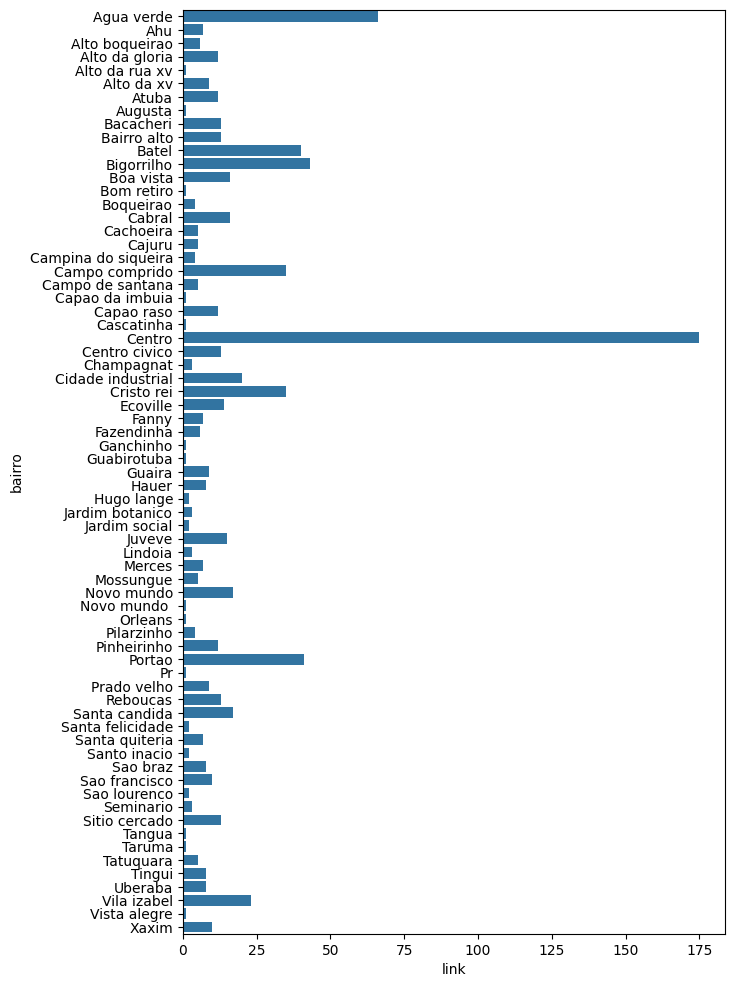

In [23]:
aux = df[['bairro','link']].groupby('bairro').count().reset_index()
plt.figure(figsize=(7,12))
sns.barplot(y = 'bairro', x = 'link', data = aux)

Analisando a variável 'bairro' notamos alguns nomes repetidos e bairros escritos nomes populares diferentes ou apelidos (assim como Ecovile e Mossungue), logo o nome desses bairros será padronizado

# Filtrando Variáveis

## Removendo Erros do dataset

In [24]:
df = df.loc[df['vagas_garagem']<10]
df = df.loc[df['quartos']>0]
df = df.loc[df['banheiros']>0]
df = df.loc[df['area'] > 5]
df = df.reset_index(drop=True)

In [25]:
df['bairro'] = df['bairro'].str.strip()

ajustes = {
    'Ecoville':'Mossungue',
    'Champagnat':'Bigorrilho',
    'Alto da rua xv': 'Alto da xv',
    'Novo mundo ': 'Novo mundo'
}

df['bairro'] = df['bairro'].replace(ajustes)

# Feature Engineering

### Info dos bairros

Informações coletadas da wikipedia sobre os bairros de curitiba 

In [26]:
infos_curitiba = get_infos_curitiba()
infos_curitiba['Bairro'] = infos_curitiba['Bairro'].apply(lambda x: unidecode(x).capitalize().strip())
infos_curitiba = infos_curitiba.drop_duplicates('Bairro')
infos_curitiba[[ 'Área (km²)', 'Homens', 'Mulheres', 'Total', 'Domicilios particulares', 'Rendimento mensal médio porresponsáveis dos domicílios (R$)']] = infos_curitiba[[ 'Área (km²)', 'Homens', 'Mulheres', 'Total', 'Domicilios particulares', 'Rendimento mensal médio porresponsáveis dos domicílios (R$)']].astype('float64')
infos_curitiba.columns = ['regiao','bairro','area_total_bairro','homens','mulheres','populacao_bairro','total_domicilios_particulares','renda_mensal_por_bairro']
df = pd.merge(df, infos_curitiba, left_on = 'bairro', right_on = 'bairro', how = 'left')

### Valor Total

In [27]:
df.loc[:,'valor_total'] = df['aluguel'] + df['condominio'] + df['seguro_incendio'] + df['iptu']

### Preço m²

In [28]:
df['preco_metro_2'] = df[['area','valor_total']].apply(lambda x: np.nan if x['area'] < 2 else x['valor_total']/x['area'], axis = 1).astype('float')

### Banheiros

In [29]:
# df['banheiros'] = df['banheiros'] + df['suites']

# Análise Exploratória de Dados

- Neste tópico, vamos entender a distribuição e a relação entre as variáveis

In [30]:
df1 = df.copy()

In [31]:
sns.set_palette('muted')
LAYOUT_PALETTE = 'muted'

## Análise Univariada

- Entender a distribuição da variável em relação à ela mesma

### Variáveis Numéricas

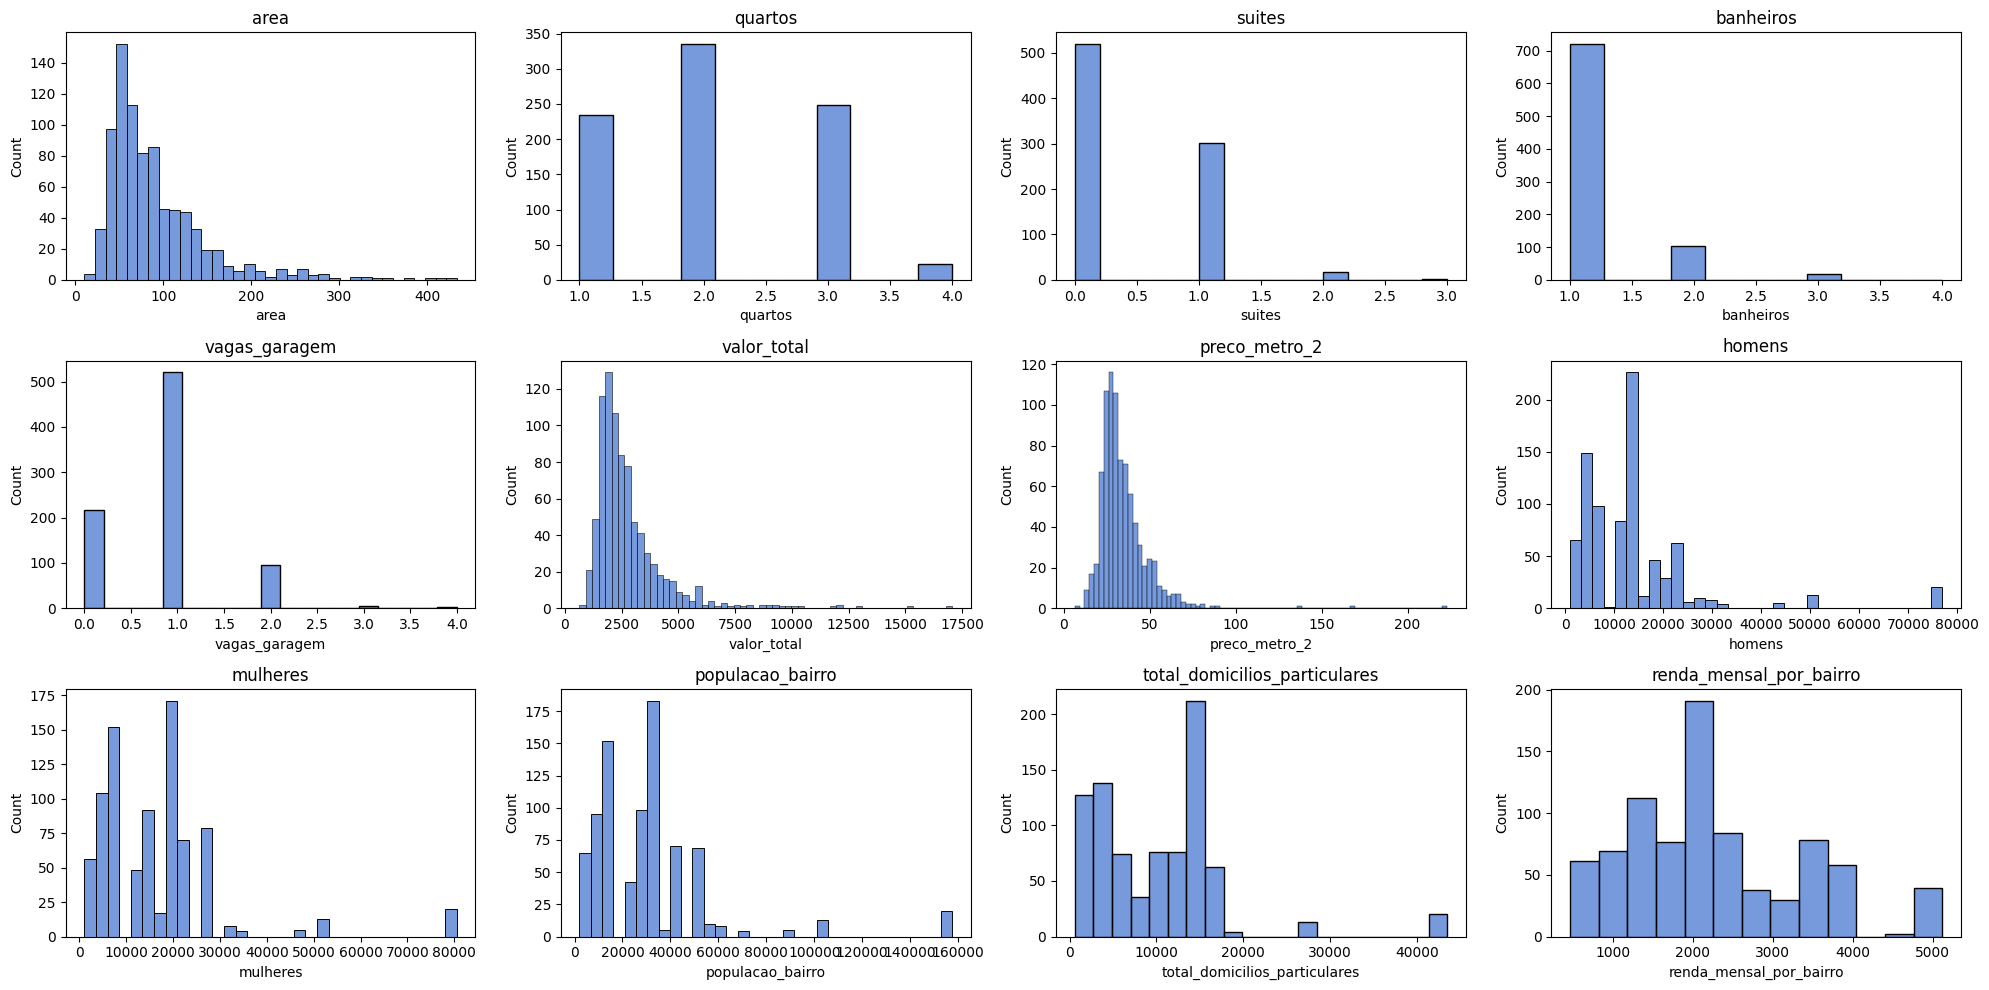

In [32]:
columns = ['area', 'quartos', 'suites', 'banheiros', 'vagas_garagem', 'valor_total', 'preco_metro_2', 'homens', 'mulheres', 'populacao_bairro', 'total_domicilios_particulares','renda_mensal_por_bairro']

aux = df1[columns].copy()
n_features = aux.shape[1]

rows = int(np.floor(np.sqrt(n_features)))
cols = int(np.ceil(n_features/rows))

grid = gridspec.GridSpec(rows,cols)
plt.figure(figsize=(20,10))

for row in range(rows):
    for col in range(cols):
        plt.subplot(grid[row,col])
        n = (row*cols) + col
        column_name = aux.columns.tolist()[n]
        plt.title(column_name)
        plt.subplot(grid[row,col])
        sns.histplot(aux[column_name])

plt.tight_layout()

Aqui, podemos perceber que as variáveis estão mais ajustadas, sem a presença de valores sem sentido ou outliers muito significativos.

Somos capazes de perceber uma clara distribuição normal em algumas variáveis como 'area', 'valor_total' e 'preco_metro_2' enquanto outras variáveis não possuem uma distribuição muito clara

### Variáveis Categóricas

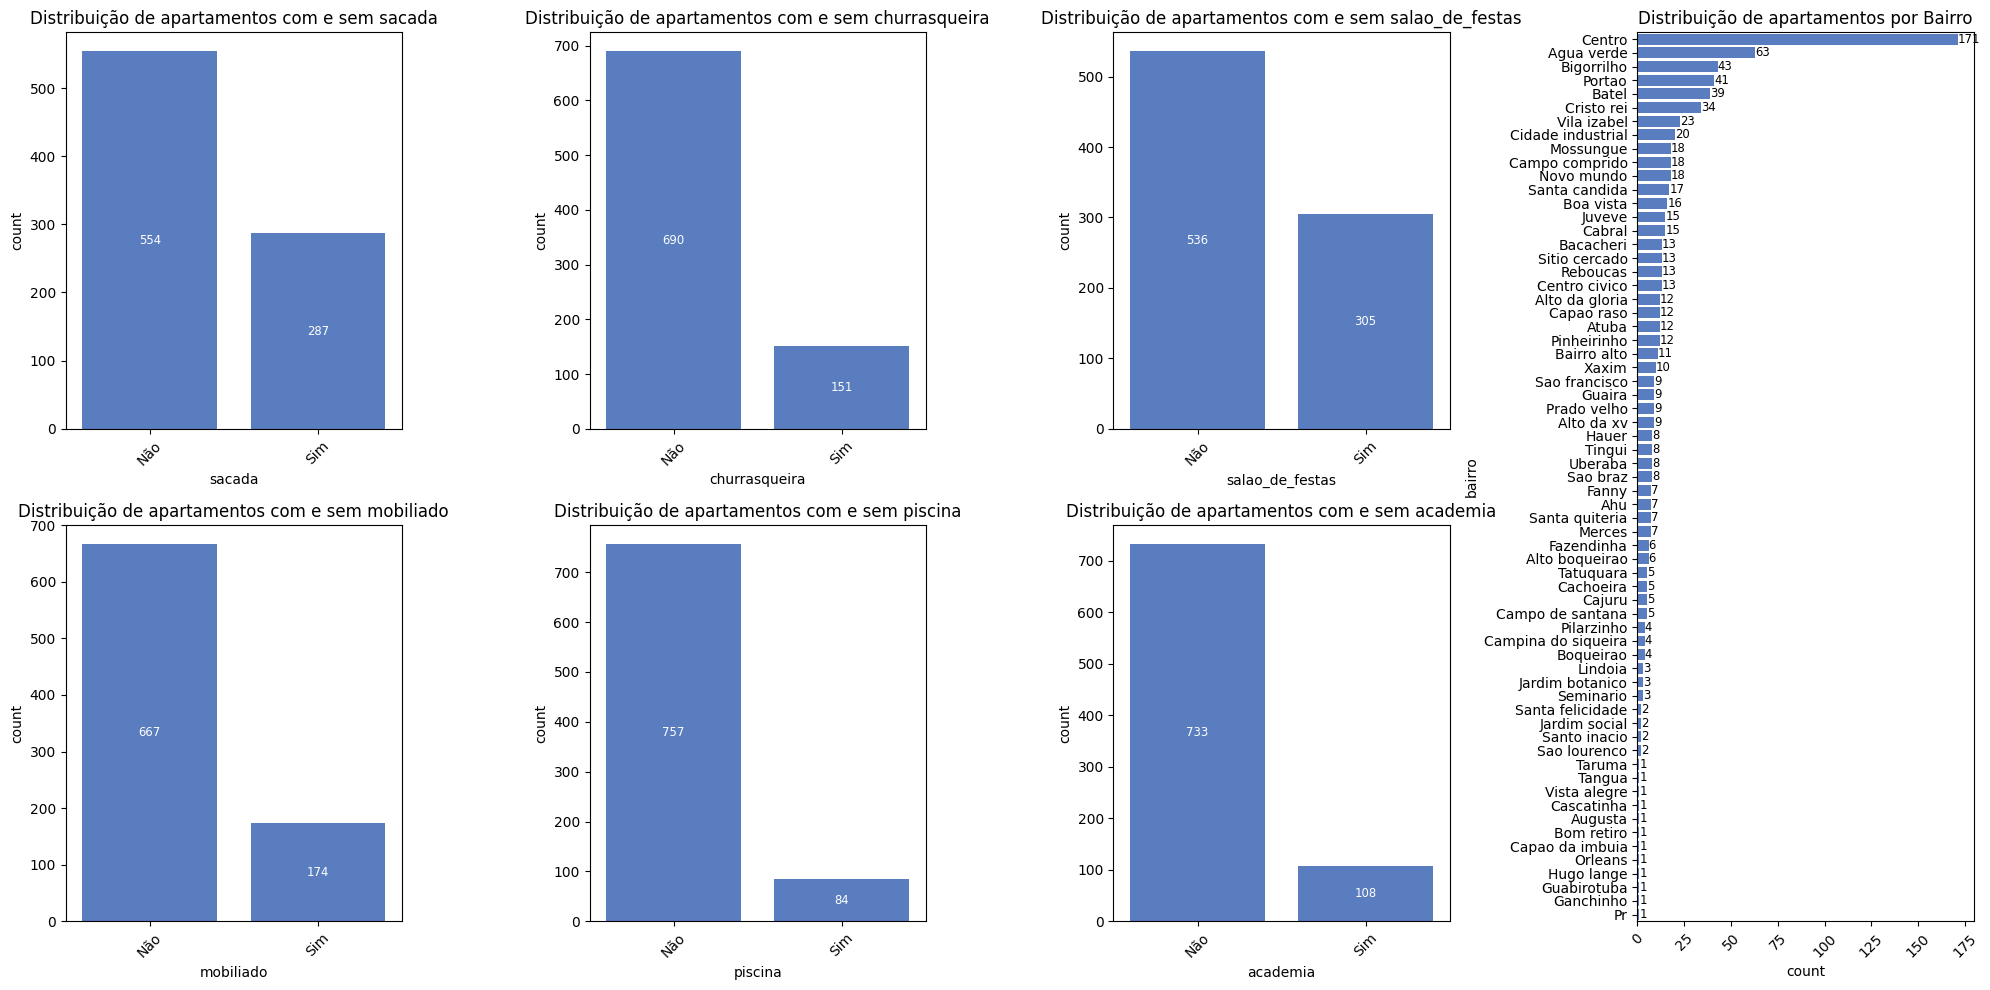

In [33]:
grid = gridspec.GridSpec(2,4)
plt.figure(figsize=(20,10))

cols = ['mobiliado', 'piscina','academia', 'sacada', 'churrasqueira', 'salao_de_festas']

for i in range(len(cols)):
    
    q, mod = divmod(i,3)

    f1 = plt.subplot
    col = cols[i]
    barplot(title=f'Distribuição de apartamentos com e sem {col}',
            title_font_size=12,
            group=col,
            agg='valor_total', 
            agg_name = 'count',
            agg_func = 'count',
            data = df,
            subplot = f1,
            grid = grid[q-1,mod],
            sort=False)


barplot(title=f'Distribuição de apartamentos por Bairro',
        title_font_size=12,
        group='bairro',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'count',
        data = df,
        subplot=plt.subplot,
        grid=grid[:,3],
        orient='v',
        sort=True,
        position_label = 'edge',
        color_label = 'black',
        )

plt.tight_layout()

Aqui conseguimos notar o quão raro são alguns atributos como 'piscina' e 'academia' nos condomínios

Vemos também a predominância do centro da cidade como região com mais imóveis a sendo alugados

## Análise Bivariada

- Nesta etapa, vamos analisar o comportamento das principais features em relação ao 'valor_total' do imóvel

### Bairro

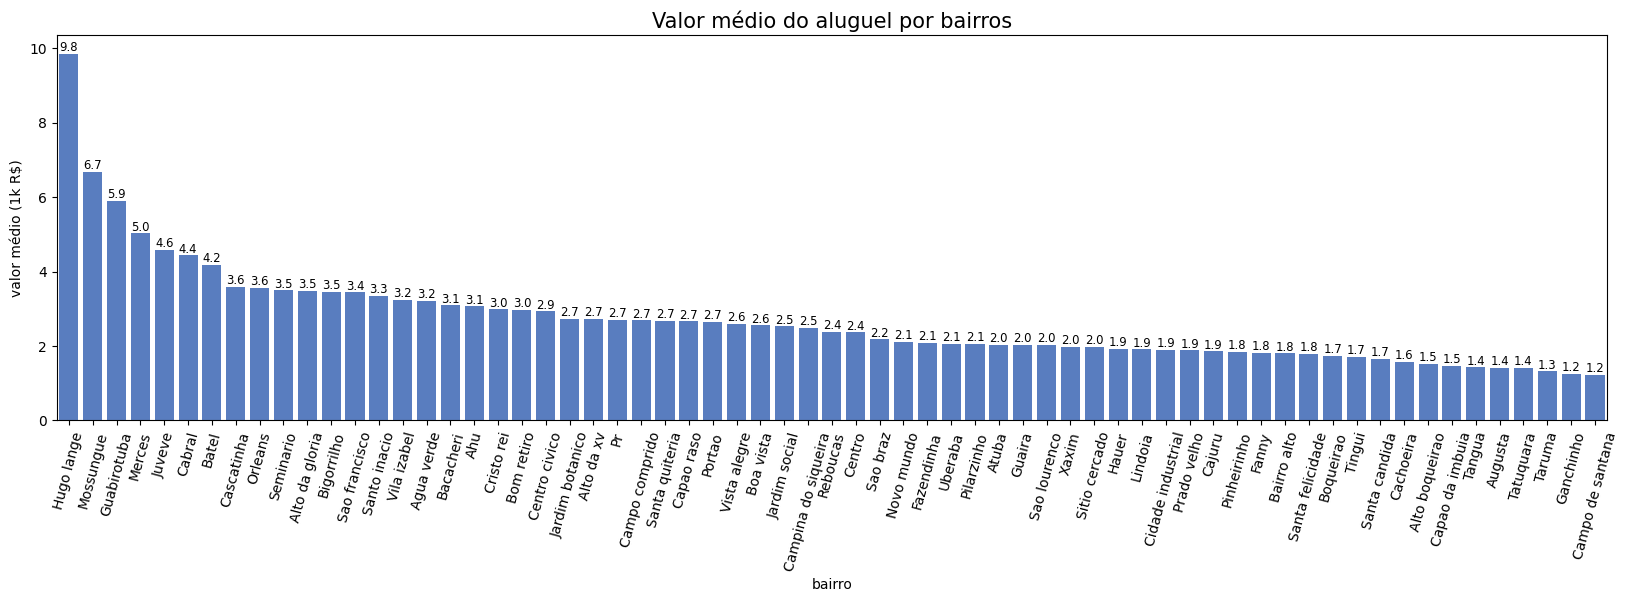

In [34]:
plt.figure(figsize=(20,5))
aux = df1[['bairro','valor_total']].copy()
aux['valor_total'] = aux['valor_total']/1000 
aux = aux[['bairro','valor_total']].groupby('bairro').agg('mean').reset_index().rename(columns={'valor_total':'valor médio (1k R$)'}).sort_values('valor médio (1k R$)', ascending=False)

plt.title('Valor médio do aluguel por bairros', fontsize=15)
g = sns.barplot(x = 'bairro', y = 'valor médio (1k R$)', data = aux, color=sns.color_palette()[0])
plt.xticks(rotation = 75)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge',fontsize = 'small',fmt='%.1f')

### Area

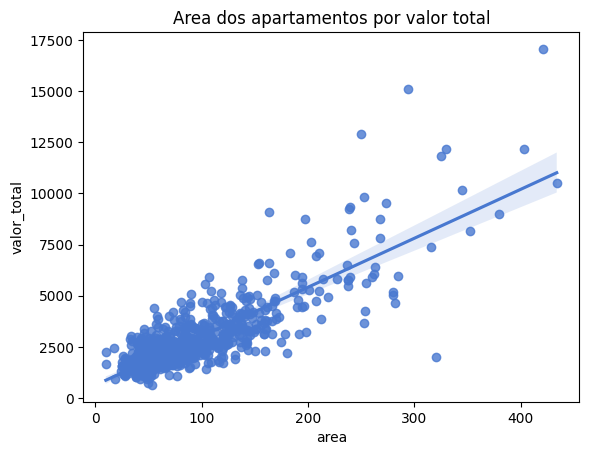

In [35]:
plt.title('Area dos apartamentos por valor total')
sns.regplot(x = 'area', y = 'valor_total', data = df1);

### Preco m²

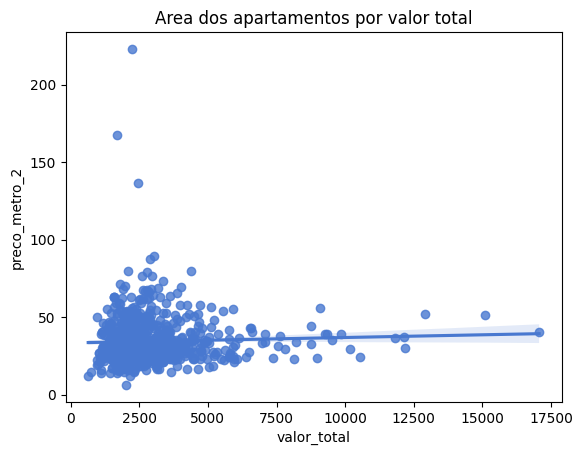

In [36]:
plt.title('Area dos apartamentos por valor total')
sns.regplot(x = 'valor_total', y = 'preco_metro_2', data = df1,marker = 'o');

### Quartos

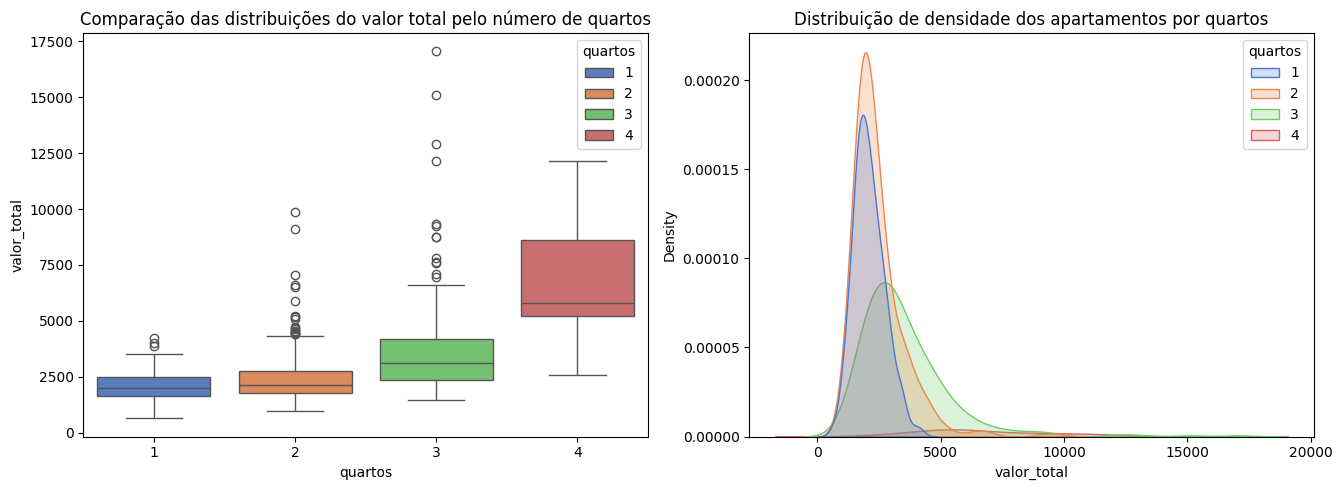

In [37]:
plt.figure(figsize=(20,5))

sns.set_palette('cividis')

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo número de quartos')
sns.boxplot(x='quartos' , y='valor_total', hue='quartos', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição de densidade dos apartamentos por quartos')
g = sns.kdeplot(x = 'valor_total' , hue= 'quartos',data=df1, fill=True, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Suites

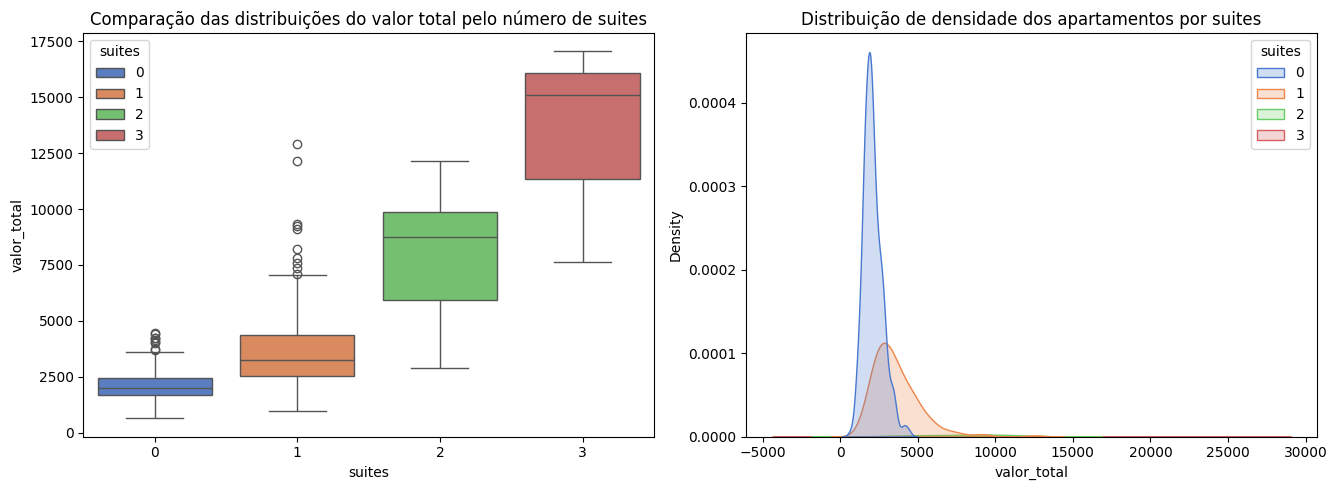

In [38]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo número de suites')
sns.boxplot(x='suites' , y='valor_total', hue='suites', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição de densidade dos apartamentos por suites')
sns.kdeplot(x = 'valor_total' , hue= 'suites',data=df1, fill=True, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Banheiros

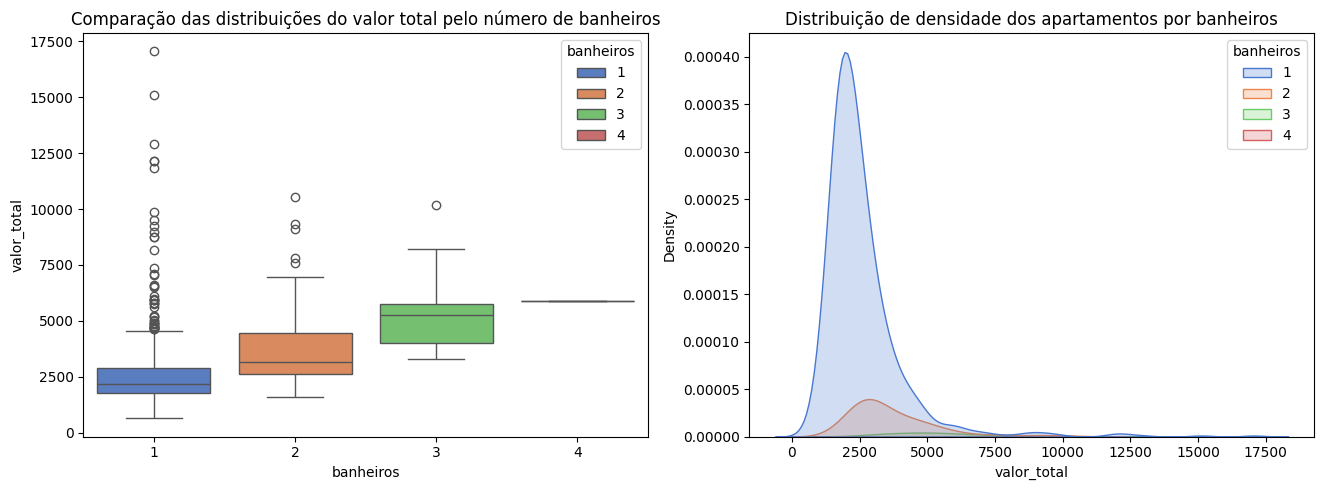

In [39]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo número de banheiros')
sns.boxplot(x='banheiros' , y='valor_total', hue='banheiros',data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição de densidade dos apartamentos por banheiros')
sns.kdeplot(x = 'valor_total' , hue= 'banheiros',data=df1, fill=True, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Vagas garagem

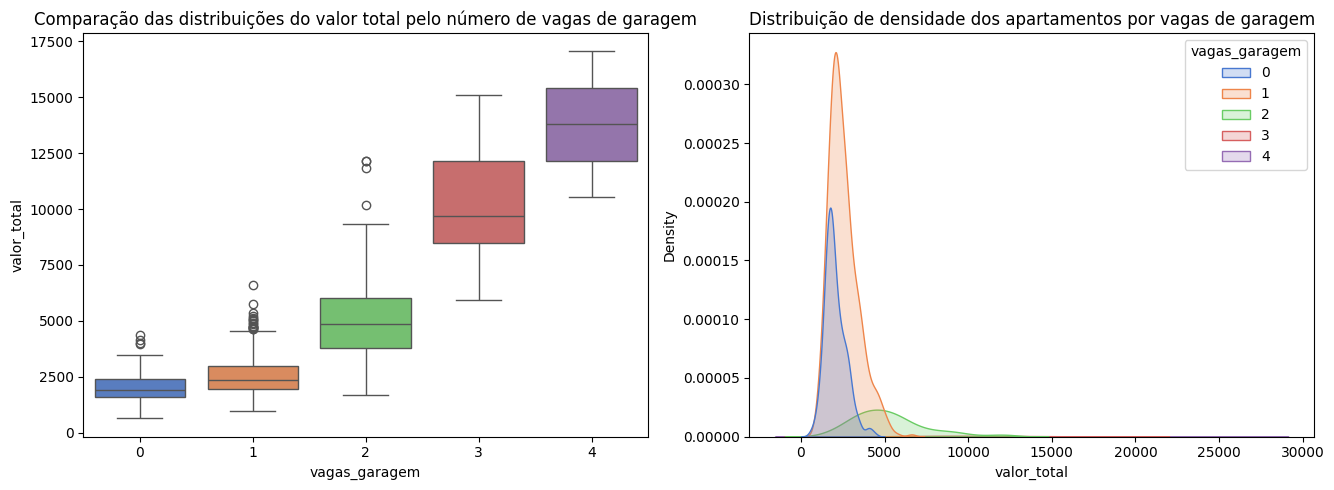

In [40]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo número de vagas de garagem')
sns.boxplot(x='vagas_garagem' , y='valor_total', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição de densidade dos apartamentos por vagas de garagem')
sns.kdeplot(x = 'valor_total' , hue= 'vagas_garagem', data=df1, fill=True, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Total de Domicilios Particulares

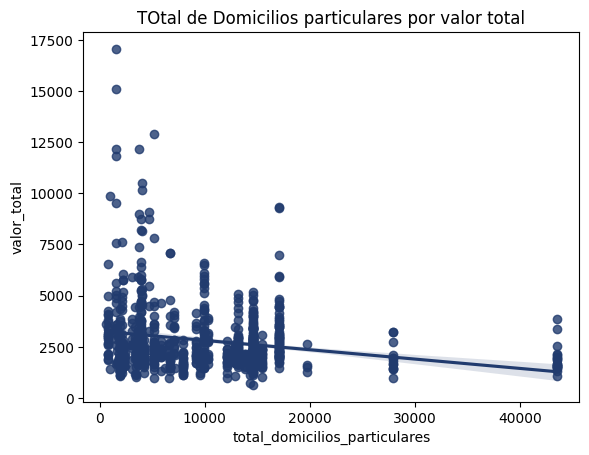

In [41]:
plt.title('TOtal de Domicilios particulares por valor total')
sns.regplot(x = 'total_domicilios_particulares', y = 'valor_total', data = df1);

### Renda Média Mensal por bairro

<Axes: xlabel='renda_mensal_por_bairro', ylabel='valor_total'>

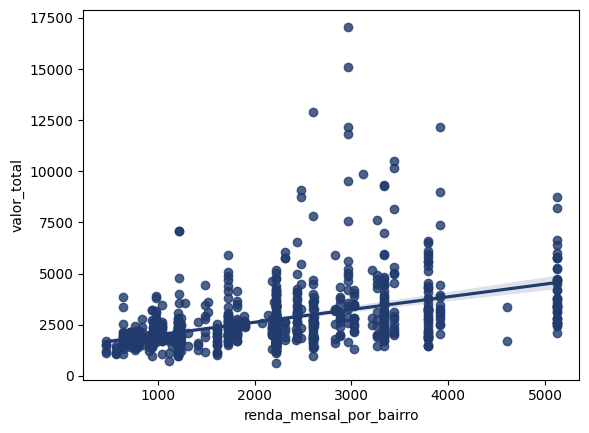

In [42]:
sns.regplot(x = 'renda_mensal_por_bairro', y = 'valor_total', data = df1)

### Mobiliado

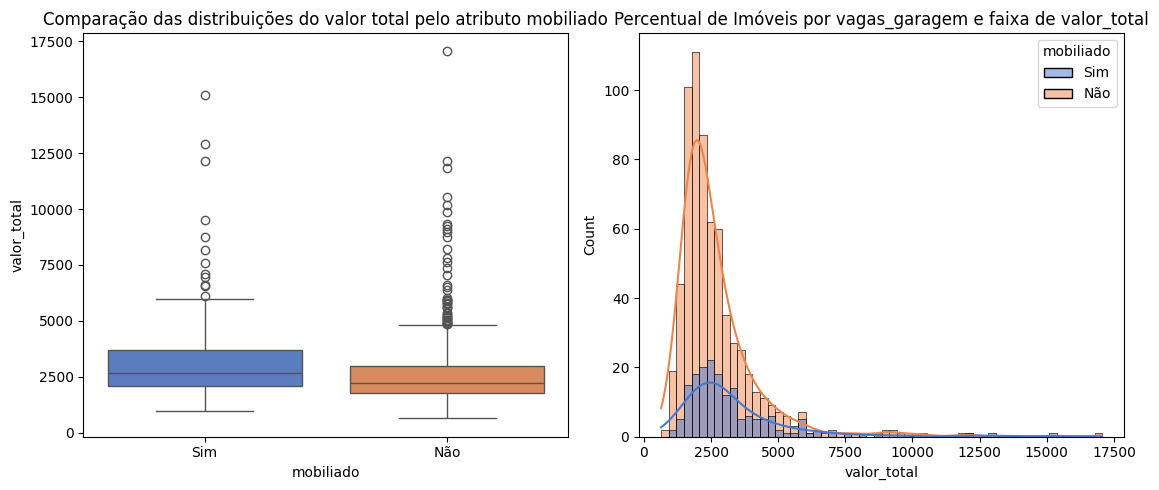

In [43]:
plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo atributo mobiliado')
sns.boxplot(x='mobiliado' , y='valor_total', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Percentual de Imóveis por vagas_garagem e faixa de valor_total')
g = sns.histplot(x = 'valor_total' , hue= 'mobiliado', hue_order=['Sim','Não'], kde = True, data=df1, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Piscina

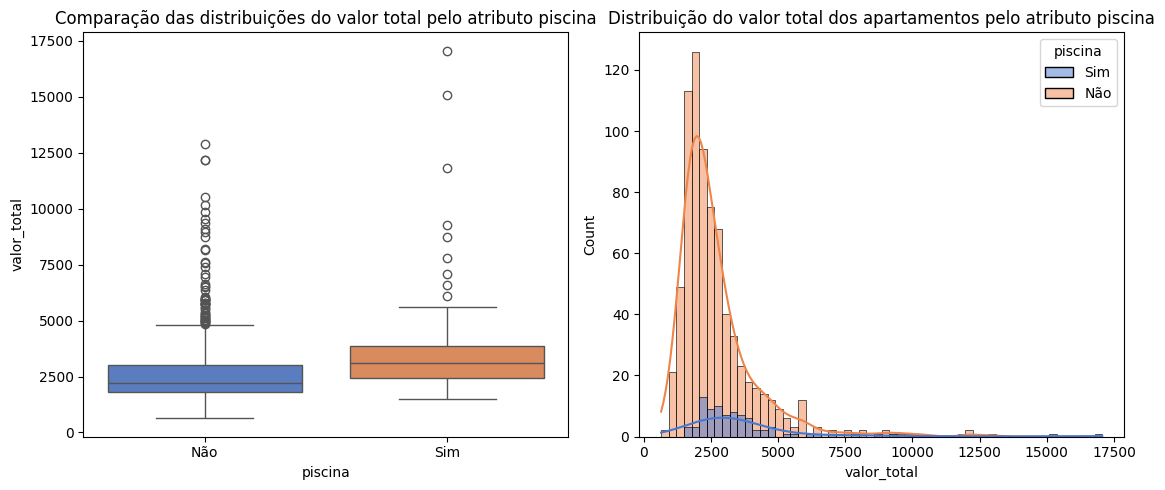

In [44]:
plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo atributo piscina')
sns.boxplot(x='piscina' , y='valor_total', hue = 'piscina', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição do valor total dos apartamentos pelo atributo piscina')
g = sns.histplot(x = 'valor_total' , hue= 'piscina', hue_order=['Sim','Não'], kde = True,data=df1, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Academia

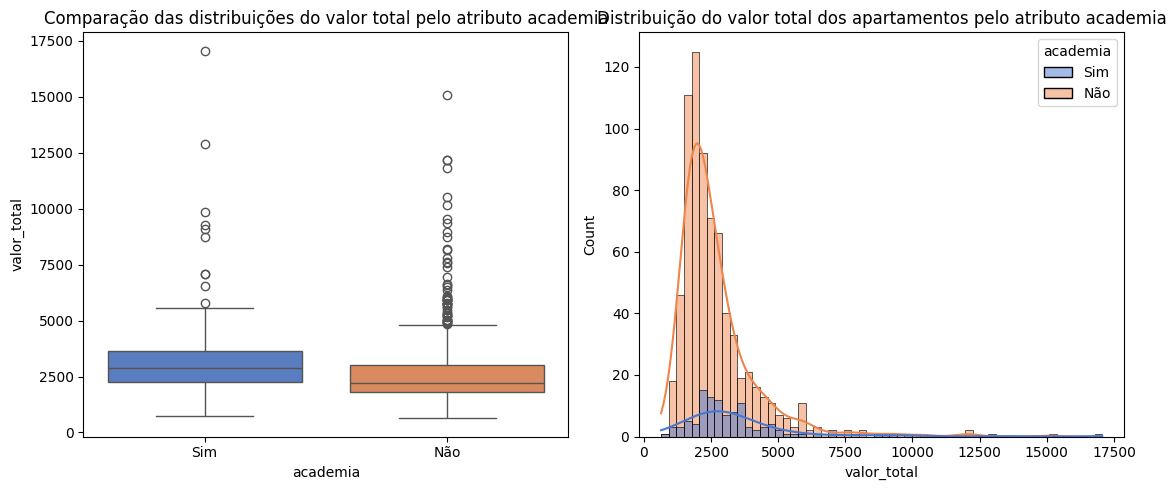

In [45]:
plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo atributo academia')
sns.boxplot(x='academia' , y='valor_total', hue = 'academia', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição do valor total dos apartamentos pelo atributo academia')
g = sns.histplot(x = 'valor_total' , hue= 'academia',hue_order=['Sim','Não'], data=df1, kde = True, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Sacada

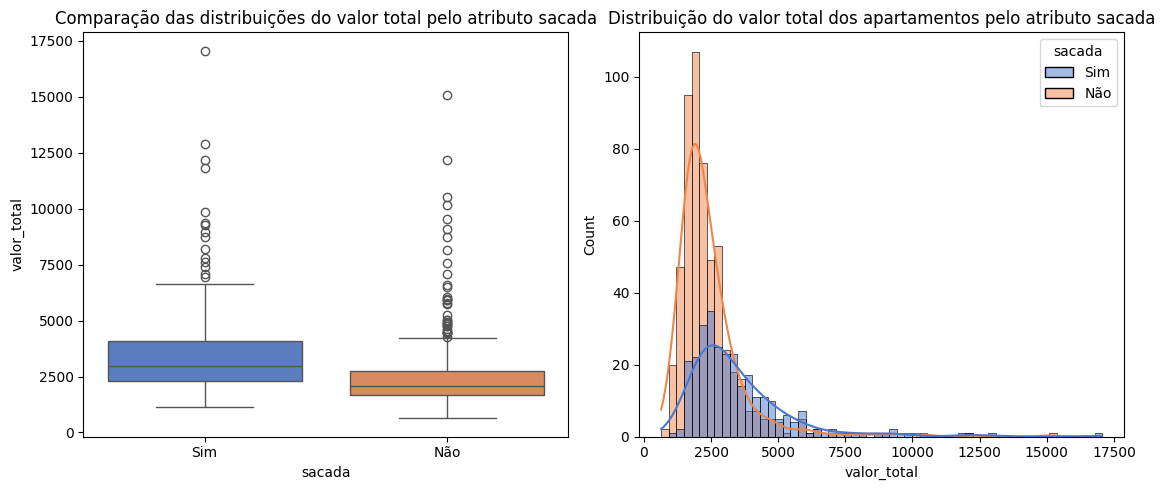

In [46]:
plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo atributo sacada')
sns.boxplot(x='sacada' , y='valor_total', hue = 'sacada', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição do valor total dos apartamentos pelo atributo sacada')
g = sns.histplot(x = 'valor_total' , hue= 'sacada',data=df1, hue_order=['Sim','Não'], kde=True, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Churrasqueira

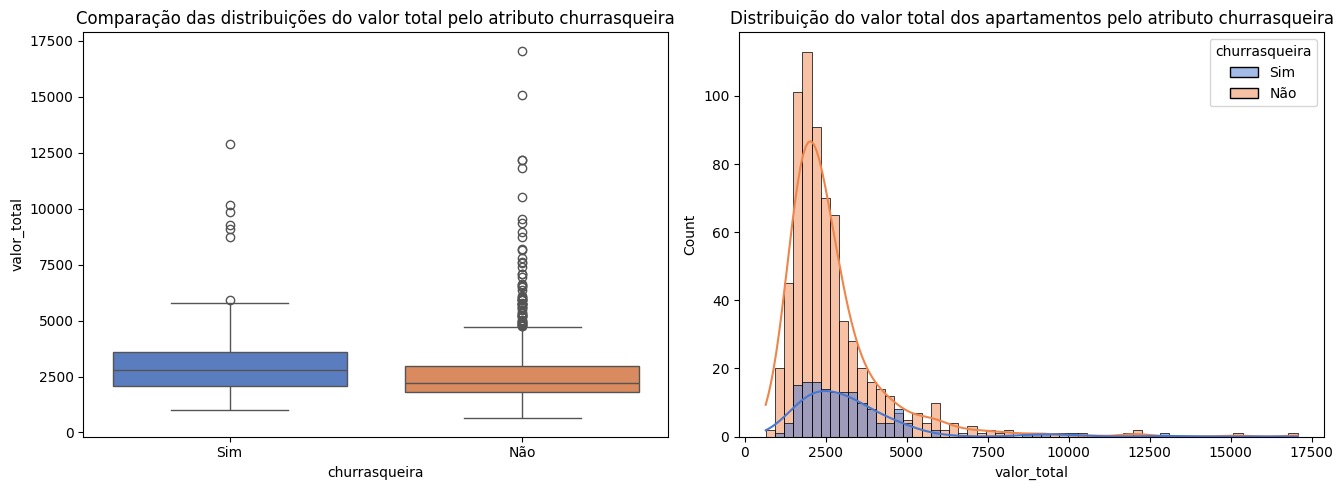

In [47]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo atributo churrasqueira')
sns.boxplot(x='churrasqueira' , y='valor_total', hue = 'churrasqueira', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição do valor total dos apartamentos pelo atributo churrasqueira')
g = sns.histplot(x = 'valor_total' , hue= 'churrasqueira',data=df1, hue_order=['Sim','Não'], kde=True, palette = LAYOUT_PALETTE)

plt.tight_layout()

### Salão de festas

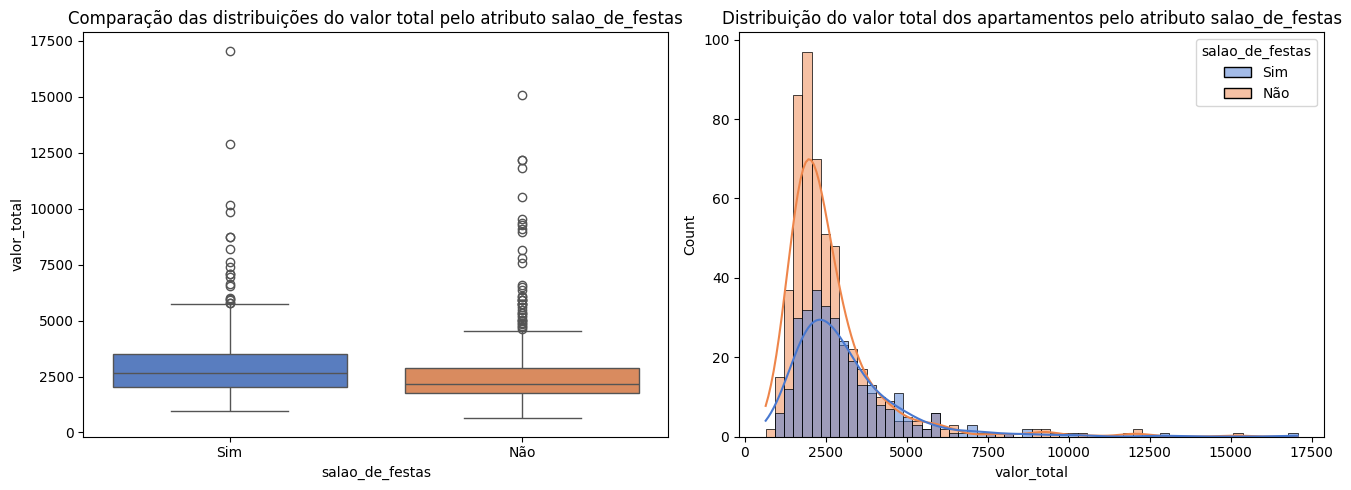

In [48]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title('Comparação das distribuições do valor total pelo atributo salao_de_festas')
sns.boxplot(x='salao_de_festas' , y='valor_total', hue = 'salao_de_festas', data=df1, palette = LAYOUT_PALETTE)

plt.subplot(1,3,2)
plt.title('Distribuição do valor total dos apartamentos pelo atributo salao_de_festas')
g = sns.histplot(x = 'valor_total' , hue= 'salao_de_festas',data=df1, hue_order=['Sim','Não'], kde=True, palette = LAYOUT_PALETTE)

plt.tight_layout()

## Análise Multivariada

- Nesta etapa o objetivo é entender a relação entre as diversas variáveis simultaneamente

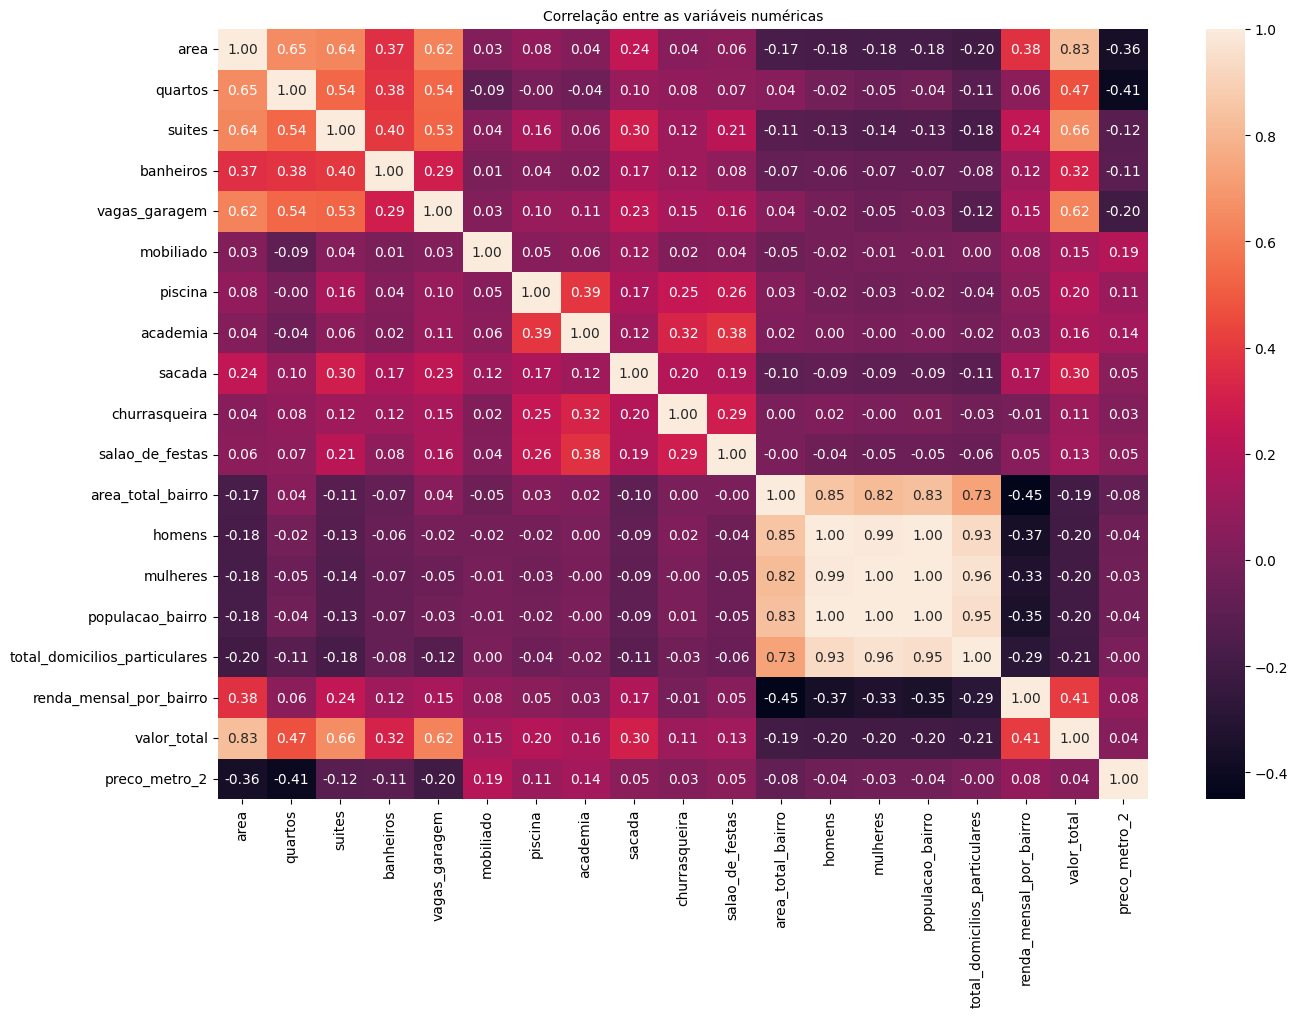

In [49]:
aux = df1.copy()

aux['mobiliado'] = df['mobiliado'].map({'Sim':1,'Não':0})
aux['piscina'] = df['piscina'].map({'Sim':1,'Não':0})
aux['academia'] = df['academia'].map({'Sim':1,'Não':0})
aux['sacada'] = df['sacada'].map({'Sim':1,'Não':0})
aux['churrasqueira'] = df['churrasqueira'].map({'Sim':1,'Não':0})
aux['salao_de_festas'] = df['salao_de_festas'].map({'Sim':1,'Não':0})

plt.figure(figsize=(15,10))
num_attributes = aux.drop(columns=['aluguel','condominio','seguro_incendio','iptu']).select_dtypes(include=['int64','float64'])
correlations = num_attributes.corr(method='pearson')
plt.title('Correlação entre as variáveis numéricas',fontsize=10)
sns.heatmap(correlations,annot=True,fmt = '.2f');

## Teste de Hipóteses

### 1) O preço do metro quadrado de studios é maior que o preço do metro quadrado de outros apartamentos?

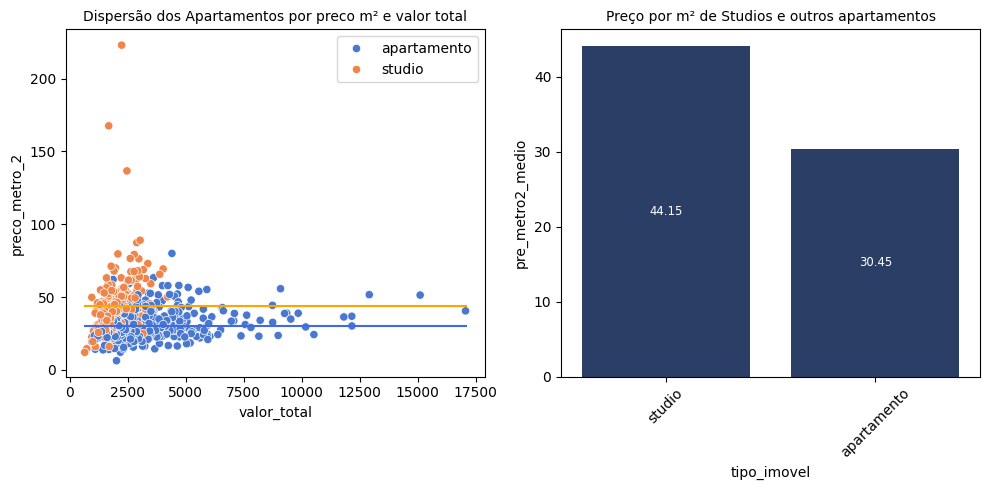

In [50]:
grid = gridspec.GridSpec(1,2)

aux1 = df1.copy()
aux1['tipo_imovel'] = aux1[['quartos','banheiros']].apply(lambda x: 'studio' if (x['quartos'] == 1) else 'apartamento', axis = 1)
aux2 = aux1[['tipo_imovel','preco_metro_2']].groupby('tipo_imovel').mean().reset_index()

plt.figure(figsize=(10,5))

plt.subplot(grid[0,0])
plt.title('Dispersão dos Apartamentos por preco m² e valor total', fontsize= 10)
sns.scatterplot(x = 'valor_total',y='preco_metro_2', hue = 'tipo_imovel', data = aux1, palette = LAYOUT_PALETTE)
sns.lineplot(x='valor_total', y = aux2.loc[aux2['tipo_imovel'] == 'studio', 'preco_metro_2'].tolist()[0], data = aux1, color = 'orange')
sns.lineplot(x='valor_total', y = aux2.loc[aux2['tipo_imovel'] == 'apartamento', 'preco_metro_2'].tolist()[0], data = aux1, color = 'royalblue');

barplot(
    title='Preço por m² de Studios e outros apartamentos',
    group='tipo_imovel',
    agg='preco_metro_2',
    agg_func='mean',
    agg_name='pre_metro2_medio',
    data=aux1,
    subplot=plt.subplot,
    grid=grid[0,1],
    fmt='%.2f'
)

plt.tight_layout()

### 2) Imóveis com área menor tendem à ter maior valor por m² 

<Axes: xlabel='area', ylabel='preco_metro_2'>

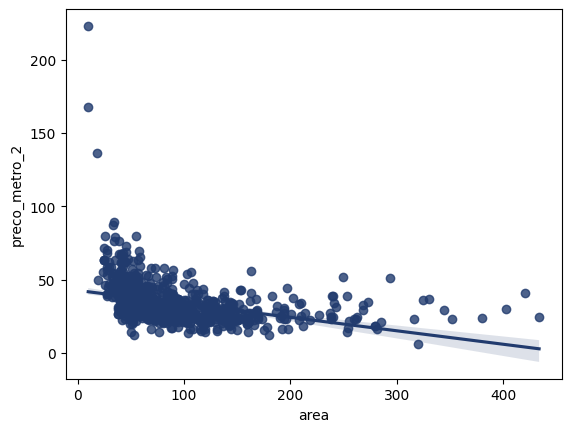

In [64]:
sns.regplot(x='area', y='preco_metro_2', data = df1)

### 3) O preço por m² dos imóveis em bairros com renda média elevada é maior do que dos outros bairros

Vemos que o preço do m² é praticamente constante quando comparamos com a renda média por bairro, logo, bairros com renda média maior não necessariamente possuem imóveis com preço por m² mais caro

Em compensação, notamos que bairros com maior renda média possuem apartamentos com maior área, o que eleva o preço médio dos alugueis
Além disso, vemos também que apartamentos em bairros mais ricos possuem mais atributos, como piscina, sacada e etc, que por sua vez também elevam o valor dos alugueis

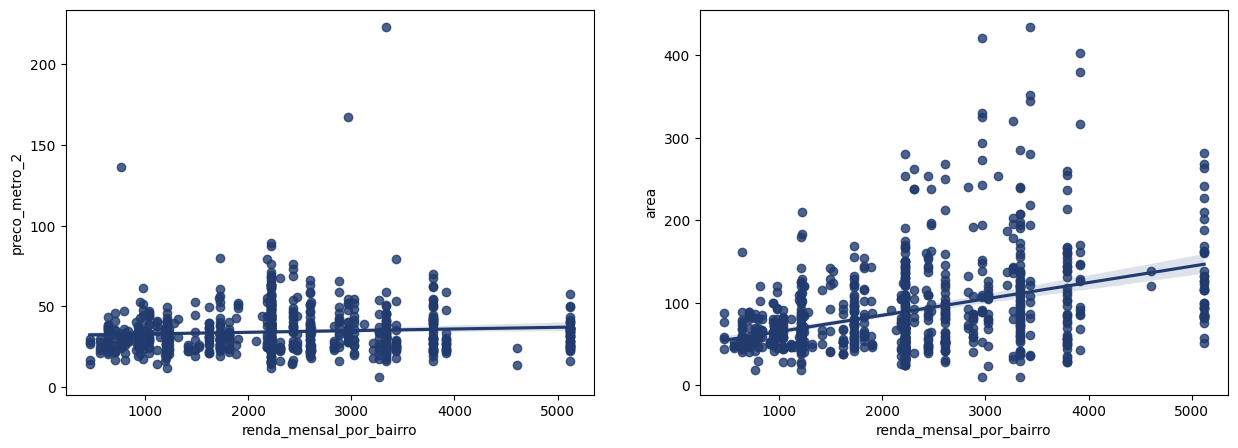

In [71]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.regplot(x = 'renda_mensal_por_bairro', y = 'preco_metro_2', data = df1)

plt.subplot(1,2,2)
sns.regplot(x = 'renda_mensal_por_bairro', y = 'area', data = df1);

### 4) Imóveis mais caros possuem com mais frequencia atributos como mobilia, sacada, churrasqueira e etc

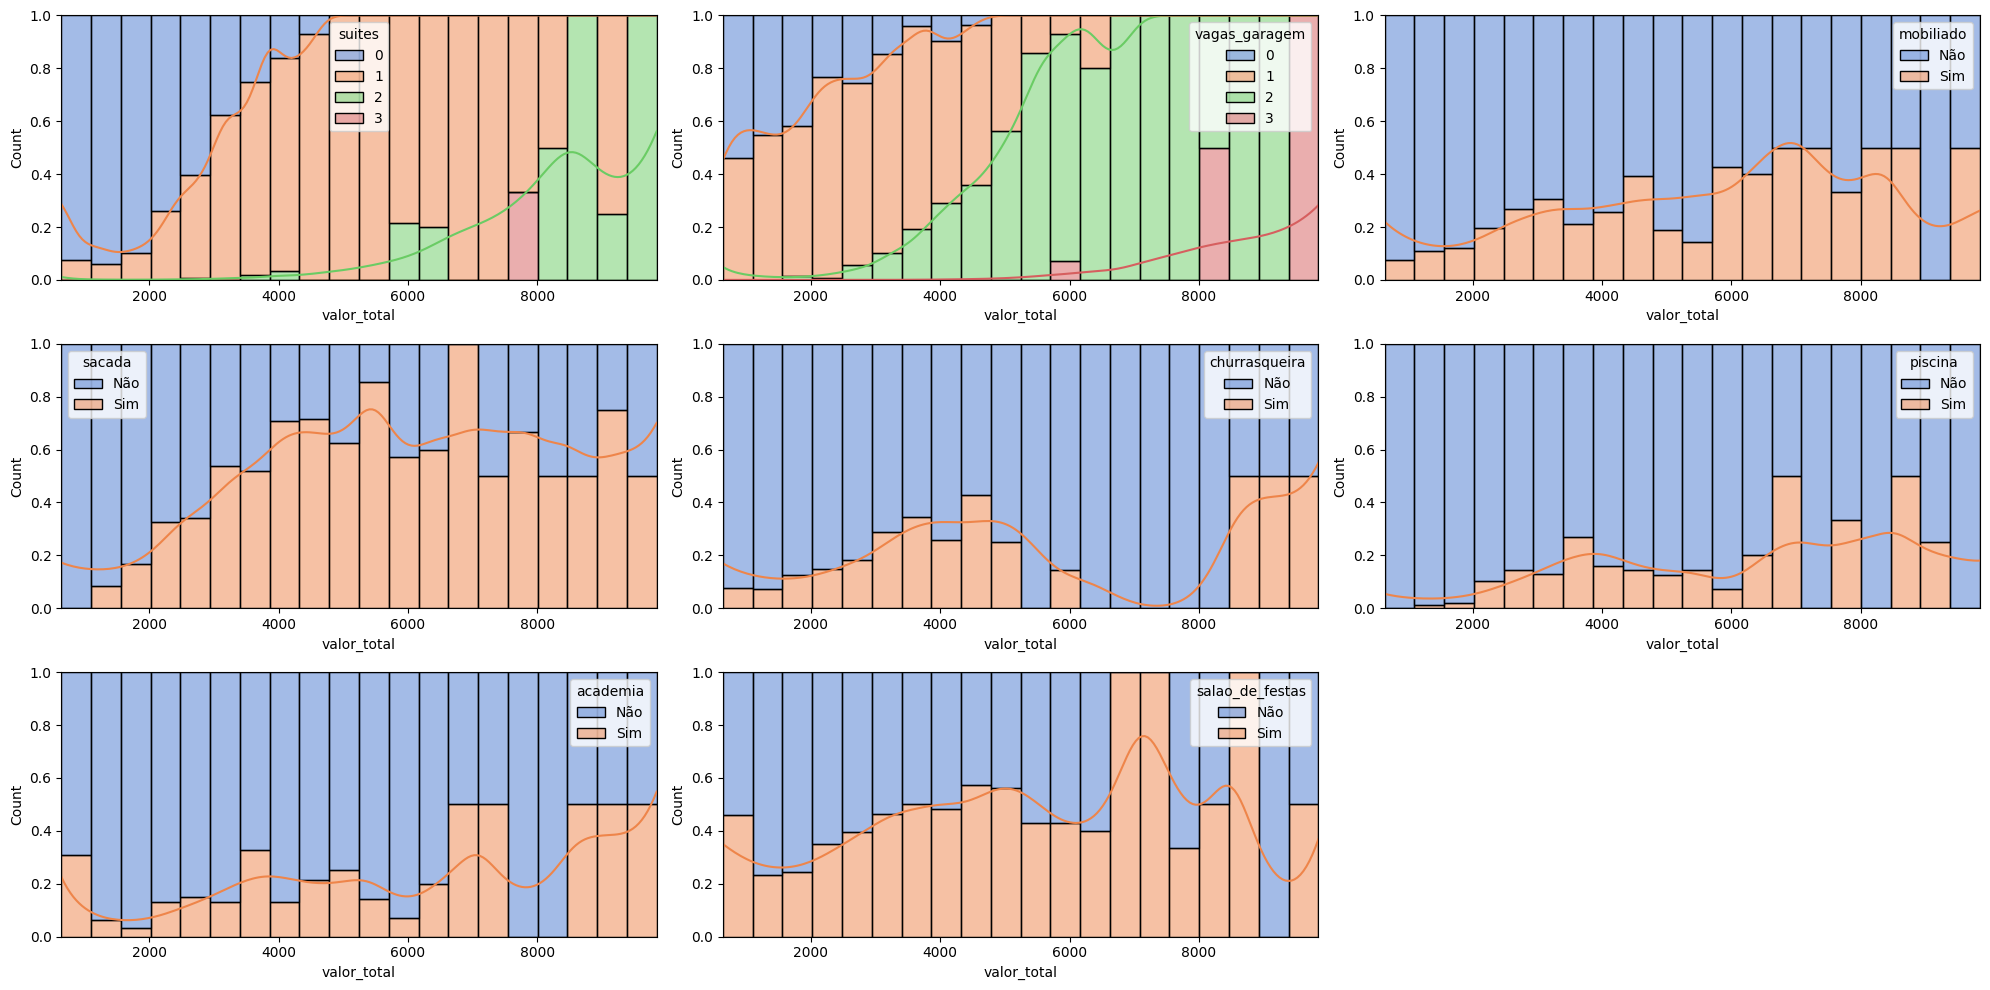

In [72]:
atributos = ['suites', 'vagas_garagem', 'mobiliado', 'sacada', 'churrasqueira', 'piscina', 'academia', 'salao_de_festas']
plt.figure(figsize=(20,10))
df_aux = df1.loc[df1['valor_total'] <10000].copy()

for col in atributos:

    plt.subplot(3,3,atributos.index(col)+1)
    sns.histplot(x = 'valor_total', hue = col, multiple = 'fill', kde = True, data = df_aux.sort_values(by=col), palette = LAYOUT_PALETTE, bins=20)

    plt.tight_layout()

### 5) Bairros com maior concentração de pessoas possuem um preço por m² maios que outros bairros

<Axes: xlabel='habitantes_por_metro2', ylabel='preco_metro_2'>

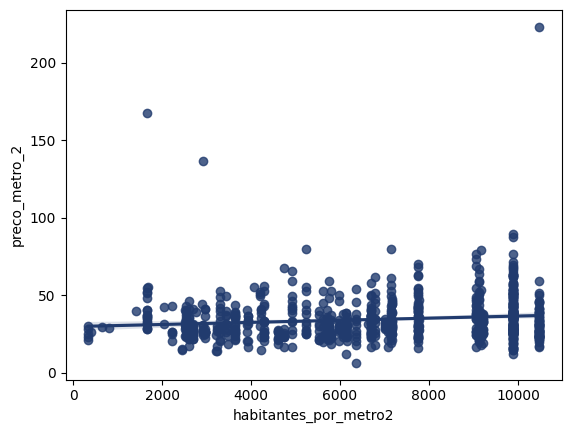

In [55]:
df_aux = df1.copy()
df_aux['habitantes_por_metro2'] = df_aux['populacao_bairro']/df_aux['area_total_bairro']
sns.regplot(x = 'habitantes_por_metro2', y = 'preco_metro_2', data = df_aux)

# Conclusão

Após explorar os dados e testar algumas hipóteses, podemos chegar à algumas conclusões sobre o comportamento dos preços do alugueis na cidade de Curitiba.

1) Imóveis menores, em média, são mais caros, ou seja, possuem um preço por m² maior do que os outros imóveis
- Observamos que imóveis menores tem o preço por m² maior do que os outros imóveis, e isso pode der devido à algumas hipóteses que podemos testar futuramente como o preço de venda do m² desses imóveis também é maior em relação aos outros ou então devido à maior procura por imóvies do tipo studio seu preço se eleve, mas o fato é que o preço de seu m² é maior quando comparado à imóveis maiores

2) O bairro do imóvel não encarece o imóvel em si. A área e a presença de mais atributos são mais relevantes para encarecer os alugueis
- É notório que o valor médio dos alugueis de determinados bairros (com renda média maior) é maior do que o de outros bairros, mas fica claro que esse aumento no preço não se deve ao bairro em si e sim às características do imóvel. Imóvel em bairros com renda média maior, apresentam também maior área, e mais atributos como suite, vagas de garagem e condomínios mais sofisticados e isso sim parece ser mais determinante para o aumento do preço do que a própria localidade em sim.

